In [ ]:
#install all needed libarys for modeling and visulizations 
import pandas as pd
import numpy as np
import sklearn
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
!pip install category_encoders==2.*
from category_encoders import OrdinalEncoder
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
import seaborn as sns
!pip install shap
!pip install pdpbox
from pdpbox.pdp import pdp_isolate, pdp_interact, pdp_plot, pdp_interact_plot
from sklearn.ensemble import RandomForestRegressor
!pip install pandas-profiling==2.*
#import plotly for graphing
!pip install plotly==4.5
import plotly
import plotly.express as px
import plotly.io as pio
#import chart studio to save graphs
!pip install chart_studio
import chart_studio
Username = 'Bhoss13'
Api_key = 'wxvH0EWkWbLxBRxKnOr8'
chart_studio.tools.set_credentials_file(username=Username, api_key=Api_key)
import chart_studio.plotly as py
import chart_studio.tools as tls
import plotly.graph_objects as go
import matplotlib.pyplot as plt


In [7]:
#create dataframe from csv
#set display so that all rows are avaiable to view to make sure I can tell what
#countries are in the list and how many iterations of each there is
url  = '/content/Life Expectancy Data.csv'
Life = pd.read_csv(url)
pd.set_option('display.max_columns', None)
pd.set_option("max_columns", None)
pd.set_option('display.max_rows', 3000)

#rename columns for clarity and readabilitiy as the original dataframe had a ton of 
#loose spaces at the beginning and end of the columns titles making it a pain to call on them 
Life.rename(columns={'Life expectancy ': 'Life expectancy', 'Measles ':'Measles',
                     ' BMI ': 'BMI', 'under-five deaths ':'Under-five deaths',
                     'Diphtheria ':'Diphtheria', ' HIV/AIDS':'HIV/AIDS',
                     ' thinness  1-19 years':'Thinness  10-19 years',
                     ' thinness 5-9 years':'Thinness 5-9 years'}, inplace=True)
#check and remove Nan's from any remaining columns to ensure clean data entry into models

Life.replace(to_replace=np.NaN,value=0,inplace=True)


#feature and target matrix Model 1 - this is for the xgbgregressor model only dropping
#status as its near useless for our model
y = Life['Life expectancy']
X = Life.drop(['Life expectancy','Status'], axis=1)


#validate and split - also using my validation data for test data as they're interchangable
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

############################Model 2########################################
# This is for my second model being just a linear regression model using ridge regression 
# I had to drop all the high cardinality values as they would throw major errors within the algorithm
Life1 = Life.drop(['Country'], axis= 1)
y1 = Life1['Life expectancy']
X1 = Life1.drop(['Life expectancy','Status'], axis=1)

from sklearn.model_selection import train_test_split
X_train1, X_val1, y_train1, y_val1 = train_test_split(X1, y1, test_size=0.2, random_state=42)

############################Model 3#########################################
#using this for my third model as its a pipeline similar to model 1 but using randomforestregressor to elimate the outliers

y2 = Life['Life expectancy']
X2 = Life.drop(['Life expectancy','Status'], axis=1)

from sklearn.model_selection import train_test_split
X_train2, X_val2, y_train2, y_val2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

In [5]:
# Establish Baseline
print('Baseline Accuracy:', y_train.value_counts(normalize=True).max())

Baseline Accuracy: 0.01446808510638298


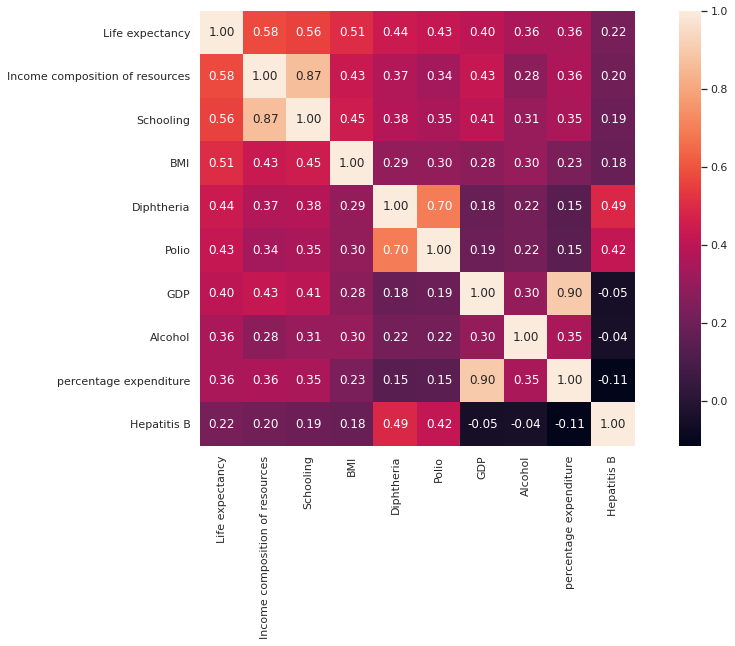

In [8]:
#create a correlation map that shows the ten highest correlated features compared to life expectancy

correlation = Life.corr(method='pearson')
columns = correlation.nlargest(10, 'Life expectancy').index
plt.figure(figsize = (16,8))
correlation_map = np.corrcoef(Life[columns].values.T)
sns.set(font_scale=1.0)
heatmap = sns.heatmap(correlation_map, cbar=True, annot=True, square=True, fmt='.2f', yticklabels=columns.values, xticklabels=columns.values)
plt.show()

In [9]:
#create pipeline to fit data for best accuracy -- model 1
#using the pipeline feature create a pipeline that starts out using ordianl encoding as ther was too many variables
# for OHE, then using a simpleimputer for any left over missing values filling them in with median if found
# finally using xgb regressor to go through and find the best possible solution to creating a high scoring prediction
#fit the model onto our training data
model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(verbose=0, copy=True),
    XGBRegressor(n_jobs=-1,n_estimators=100,learning_rate=.1)
)
model.fit(X_train, y_train);

[15:18:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [9]:
#get our training prediction using the predict function, using this info we can then 
# find our MSE along with our r^2 score to start finding a prediction scale for our models
train_pred = model.predict(X_train)
print('The Mean Squared Error:',mean_squared_error(y_train, train_pred))
print('The R2 Score:',r2_score(y_train, train_pred)*100)

The Mean Squared Error: 5.892970815939887
The R2 Score: 94.52155573706912


In [29]:
#model 2
# a simple linear model using ridge regression. Made sure to drop all high cardinality values beforehand
# as our model doesnt have any encoding so must only be deployed on float and interger values
from sklearn.linear_model import Ridge
RidgeMOD = Ridge()


# Fit model to training data
RidgeMOD.fit(X_train1, y_train1);

In [31]:
# REiterate the above segment only changing for values replaced by the ridge model
# instead of our original pipeline model
train_pred1 = RidgeMOD.predict(X_train1)
print('The Mean Squared Error:',mean_squared_error(y_train1, train_pred1))
print('The R2 Score:', r2_score(y_train1, train_pred1)*100)

The Mean Squared Error: 40.437450618884114
The R2 Score: 62.40702249002341


In [61]:
#model3
# After trying to improve the earlier xgbr regression score I learned there was 
# outliers within my data that caused the xrgb regressor to have trouble handling them
# in order to fix this issue I looked up the best way to deal with outlier within
# machine learning algorithms and found out that since the random forest regressor
# goes through each iteration it handles outliers differently from the xgbr regressor 
# this allowed me to increase my score by another 3.5% bringing me near 100% accuracy
model3 = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(verbose=0, copy=True),
    RandomForestRegressor(n_jobs=-1, max_features='auto')
)
model3.fit(X_train2, y_train2);

In [59]:
# again we are gathering our score metrics from our newly created model seeing
#another improvment within both of our metrics and 
train_pred2 = model3.predict(X_train2)
print('The Mean Squared Error:',mean_squared_error(y_train2, train_pred2))
print('The R2 Score:', r2_score(y_train2, train_pred2)*100)

The Mean Squared Error: 2.1946970421276593
The R2 Score: 97.95968352892683


In [32]:
# get the permuatation importance from our model to understand whats the driving power
# behind our feature importance, taking a deeper look than my above heat map to see
# if there was anything that was missed or slipped through the cracks
perm_imp = permutation_importance(model, X_val, y_val, n_jobs=-1)
perm_imp.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

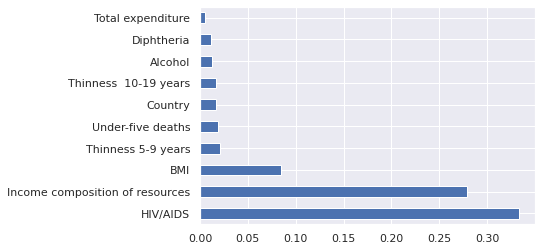

In [33]:
# display the importance mean and importance standard devaition of our model to be
# easily readable for none tech viewers
data = {'importances_mean': perm_imp['importances_mean'],
      'importances_std': perm_imp['importances_std']}
df = pd.DataFrame(data, index=X_train.columns)
df = df.sort_values('importances_mean', ascending = False)
df.head(10).importances_mean.plot(kind='barh');

In [54]:
## Showing correlations between schooling and life expectancy are positive
Schooling= px.scatter(data_frame=Life,
           x='Life expectancy',
           y='Schooling',
           hover_data=['Country'])
Schooling

# #upload graph to chart studio 
# py.plot(Schooling, filename='Schooling/LifeExpectancy', auto_open= False)
# Schooling.write_html(r"C:\Users\bmxki\Documents\Schooling.html")

In [ ]:
## Showing positive correlation between life expectancy and income composition of resources
px.scatter(data_frame=Life,
           x='Life expectancy',
           y='Income composition of resources',
           hover_data=['Country'])

# the outliers are from missing data or infrastructure that isnt in place in certain countries to record the data correctly

In [55]:
fig = px.scatter(data_frame=Life,
           x='Life expectancy',
           y='Adult Mortality',
           hover_data=['Country'])

## Showing negative correlation between adult mortality and life expectancy
# adult mortality being the chances someone dies between the ages of 15 and 60

In [ ]:
Life

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


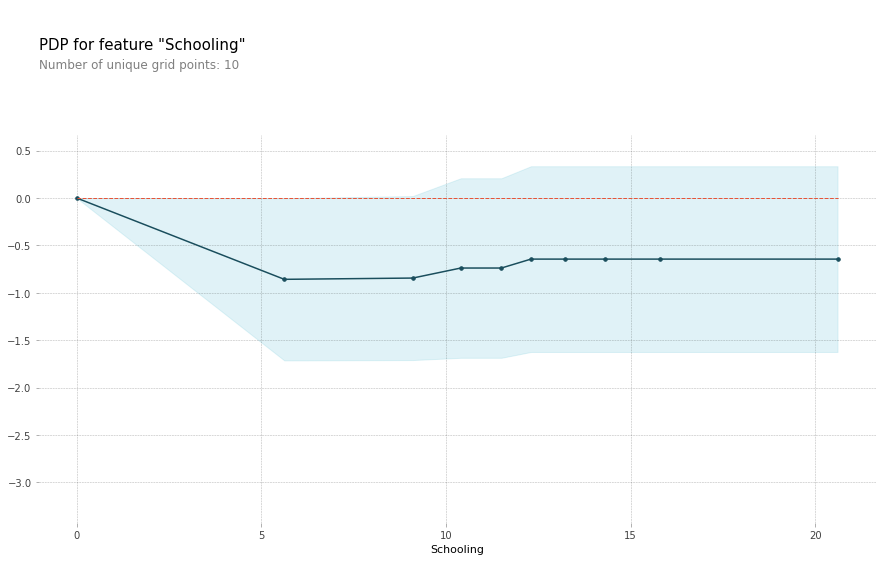

In [ ]:
#PDP showing the dependence between the schooling feature and our target feature
# in our model being life expectancy. As shown there is a dependence although not
# incredible significant
feature = 'Schooling'

isolated = pdp_isolate(
    model=model,
    dataset=X_val,
    model_features=X_val.columns,
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

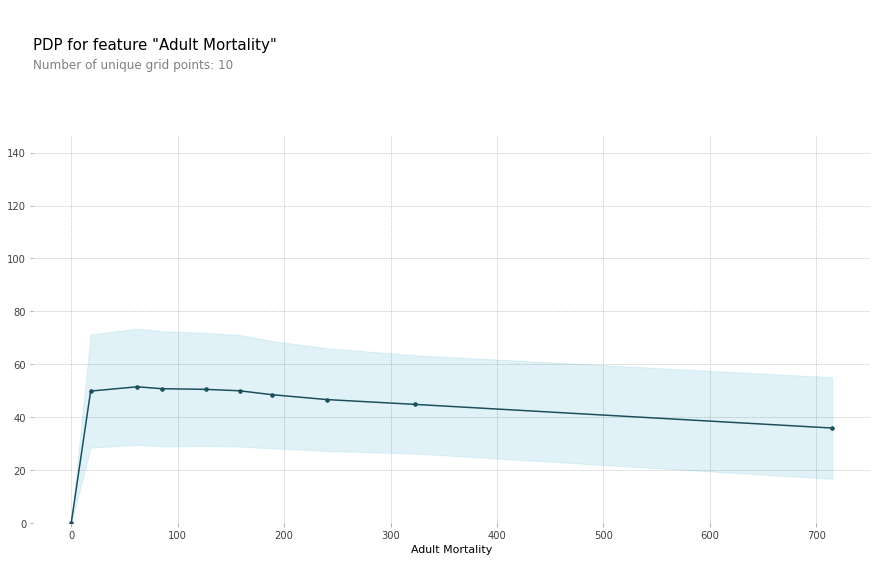

In [ ]:
# PDP showing the dependence between the adult mortality feature and our target feature
# in our model being life expectancy. As shown there is a dependence that seems 
# to show a significant correaltion between the two 

feature = 'Adult Mortality'

isolated = pdp_isolate(
    model=model,
    dataset=X_val,
    model_features=X_val.columns,
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


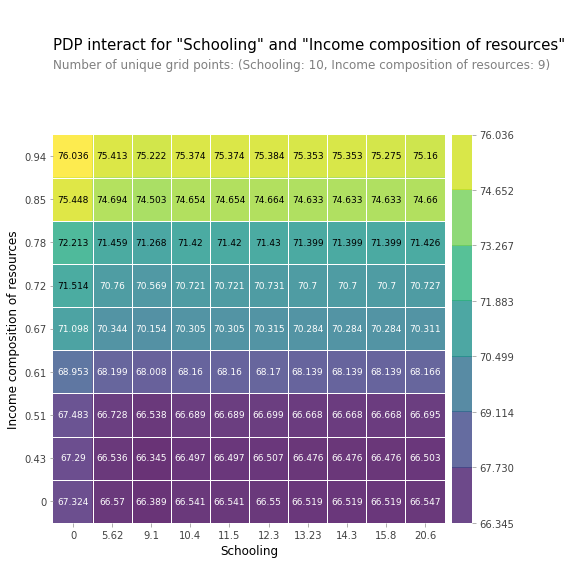

In [ ]:
# comparing our two expected main features to our target feature shows that there
# is a linear relationship although it may not be that incredibly strong because
# of our outliers in our data skewing some of our entrys 

features = ['Schooling', 'Income composition of resources']

interaction = pdp_interact(
    model=model,
    dataset=X_val,
    model_features=X_val.columns,
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

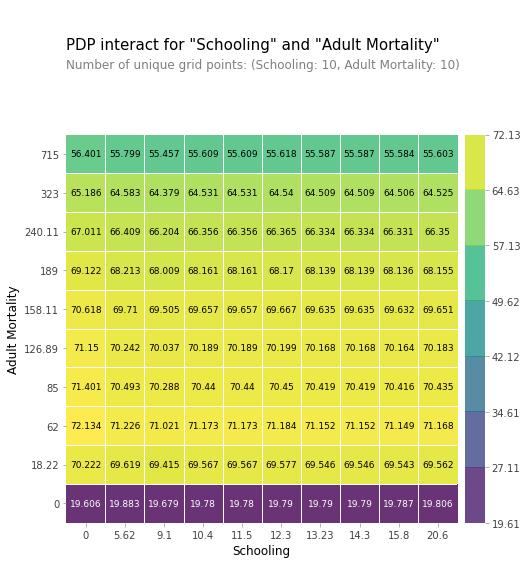

In [ ]:
# comparing two more expected main features to our target feature shows that there
# is a linear relationship although it may not be that incredibly strong because
# of our outliers in our data skewing some of our entrys 

features = ['Schooling', 'Adult Mortality']

interaction = pdp_interact(
    model=model,
    dataset=X_val,
    model_features=X_val.columns,
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

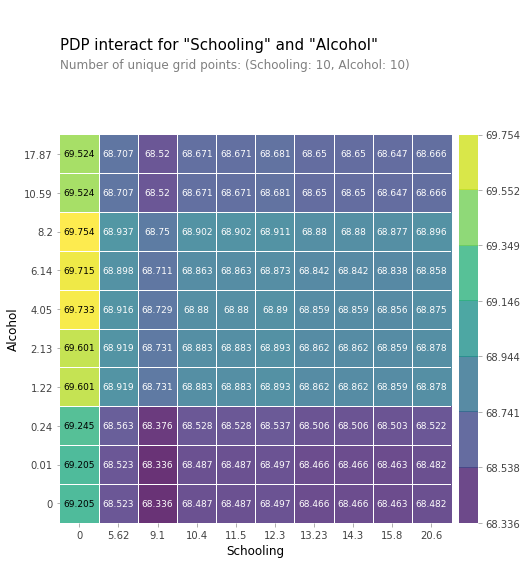

In [ ]:
# looking to see if there was any relationship present between alcohol and schooling
# found some pretty interesting information not related to our model but that most
# of the countries that didnt report schooling did report alcohol consumption
features = ['Schooling', 'Alcohol']

interaction = pdp_interact(
    model=model,
    dataset=X_val,
    model_features=X_val.columns,
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

In [ ]:
#################################################################################CONSTRUCTION ZONE############################################################################################################
################################################################################PROCEED WITH CAUTION###########################################################################################################

In [ ]:
profile1 = X_val.iloc[[1]]
profile1

In [ ]:
# explainer = shap.TreeExplainer(pipe)
# shap_values = explainer.shap_values(profile1)
# shap.initjs()
# shap.force_plot(
#     base_value=explainer.expected_value,
#     shap_values=shap_values,
#     features=profile1
# )

In [ ]:
# #upload graph to chart studio 
# py.plot(TopScorersW_MLS_Scatter, filename='Top scorers under 22', auto_open= True)

In [ ]:
Life['Country'].value_counts()

In [ ]:
import country_converter as coco
newlist = Life['Country_Code']
standard_names = coco.convert(names=newlist, to='iso3', not_found=1)


In [ ]:
['Saint Kitts and Nevis', 'Cook Islands']

In [ ]:
Life['Country']

In [67]:
len(COUNTRYCODEDIC)

245

In [71]:
print('length of country codes',len( COUNTRYCODEDIC))
print(Life.nunique()[0])

length of country codes 245
193


In [57]:
Country_codes.nunique()

171

In [47]:
Country_codes = pd.Series(Country_codes)

In [ ]:
Life.nunique()

In [ ]:
|pip install country_converter

In [86]:
pd.pivot_table(Life,values=Life['Country'])

KeyError: ignored

In [ ]:
abc = Life.groupby(by='Country') ['Life expectancy'].mean()
abc.head(200)
Life1 = pd.DataFrame(data={'Country':abc.index, 'Average_Life_Expectancy':abc.values})
Life1

In [103]:

fig = go.Figure(data=go.Choropleth(
    locations = Life1['Country'],
    z = Life1['Average_Life_Expectancy'],
    text = Life1['Country'],
    colorscale = 'Reds',
    autocolorscale=False,
    reversescale=True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    # colorbar_tickprefix = '',
    colorbar_title = 'Life Expectancy',
))

In [105]:
fig.show()

In [ ]:
Life['Country_Code'] = ['AFG', 'AFG', 'AFG', 'AFG', 'AFG', 'AFG', 'AFG', 'AFG', 'AFG', 'AFG', 'AFG', 'AFG', 'AFG', 'AFG', 'AFG',
                        'ALB', 'ALB', 'ALB', 'ALB', 'ALB','ALB', 'ALB', 'ALB', 'ALB', 'ALB','ALB', 'ALB', 'ALB', 'ALB', 'ALB',
                        'DZA', 'DZA', 'DZA','DZA', 'DZA', 'DZA','DZA', 'DZA', 'DZA','DZA', 'DZA', 'DZA','DZA', 'DZA', 'DZA',
                        'AGO', 'AGO','AGO','AGO','AGO','AGO','AGO','AGO','AGO','AGO','AGO','AGO','AGO','AGO','AGO',
                        'ATG', 'ATG', 'ATG', 'ATG', 'ATG','ATG', 'ATG', 'ATG', 'ATG', 'ATG','ATG', 'ATG', 'ATG', 'ATG', 'ATG',
                        'ARG', 'ARG', 'ARG', 'ARG', 'ARG','ARG', 'ARG', 'ARG', 'ARG', 'ARG','ARG', 'ARG', 'ARG', 'ARG', 'ARG',
                        'ARM','ARM','ARM','ARM','ARM','ARM','ARM','ARM','ARM','ARM','ARM','ARM','ARM','ARM','ARM','ARM','ARM',
                        'AUS','AUS','AUS','AUS','AUS','AUS','AUS','AUS','AUS','AUS','AUS','AUS','AUS','AUS','AUS','AUS','AUS',
                        'AUT','AUT','AUT','AUT','AUT','AUT','AUT','AUT','AUT','AUT','AUT','AUT','AUT','AUT','AUT','AUT','AUT',
                        'AZE','AZE','AZE','AZE','AZE','AZE','AZE','AZE','AZE','AZE','AZE','AZE','AZE','AZE','AZE','AZE','AZE',
                        'BHS','BHS','BHS','BHS','BHS','BHS','BHS','BHS','BHS','BHS','BHS','BHS','BHS','BHS','BHS','BHS','BHS',
                        'BHR','BHR','BHR','BHR','BHR','BHR','BHR','BHR','BHR','BHR','BHR','BHR','BHR','BHR','BHR','BHR','BHR',
                        'BGD','BGD','BGD','BGD','BGD','BGD','BGD','BGD','BGD','BGD','BGD','BGD','BGD','BGD','BGD','BGD','BGD',
                        'BRB','BRB','BRB','BRB','BRB','BRB','BRB','BRB','BRB','BRB','BRB','BRB','BRB','BRB','BRB','BRB','BRB',
                        'BLR','BLR','BLR','BLR','BLR','BLR','BLR','BLR','BLR','BLR','BLR','BLR','BLR','BLR','BLR','BLR','BLR',
                        'BLZ','BLZ','BLZ','BLZ','BLZ','BLZ','BLZ','BLZ','BLZ','BLZ','BLZ','BLZ','BLZ','BLZ','BLZ','BLZ','BLZ',
                        'BEN','BEN','BEN','BEN','BEN','BEN','BEN','BEN','BEN','BEN','BEN','BEN','BEN','BEN','BEN','BEN','BEN',
                        'BTN','BTN','BTN','BTN','BTN','BTN','BTN','BTN','BTN','BTN','BTN','BTN','BTN','BTN','BTN','BTN','BTN',
                        'BOL','BOL','BOL','BOL','BOL','BOL','BOL','BOL','BOL','BOL','BOL','BOL','BOL','BOL','BOL','BOL','BOL',
                        'BIH','BIH','BIH','BIH','BIH','BIH','BIH','BIH','BIH','BIH','BIH','BIH','BIH','BIH','BIH','BIH','BIH',
                        'BWA','BWA','BWA','BWA','BWA','BWA','BWA','BWA','BWA','BWA','BWA','BWA','BWA','BWA','BWA','BWA','BWA',
                        'BRA','BRA','BRA','BRA','BRA','BRA','BRA','BRA','BRA','BRA','BRA','BRA','BRA','BRA','BRA','BRA','BRA',
                        'BRN','BRN','BRN','BRN','BRN','BRN','BRN','BRN','BRN','BRN','BRN','BRN','BRN','BRN','BRN','BRN','BRN',
                        'BGR','BGR','BGR','BGR','BGR','BGR','BGR','BGR','BGR','BGR','BGR','BGR','BGR','BGR','BGR','BGR','BGR',
                        'BFA','BFA','BFA','BFA','BFA','BFA','BFA','BFA','BFA','BFA','BFA','BFA','BFA','BFA','BFA','BFA','BFA',
                        'BDI','BDI','BDI','BDI','BDI','BDI','BDI','BDI','BDI','BDI','BDI','BDI','BDI','BDI','BDI','BDI','BDI',
                        'CPV','CPV','CPV','CPV','CPV','CPV','CPV','CPV','CPV','CPV','CPV','CPV','CPV','CPV','CPV','CPV','CPV',
                        'KHM','KHM','KHM','KHM','KHM','KHM','KHM','KHM','KHM','KHM','KHM','KHM','KHM','KHM','KHM','KHM','KHM',
                        'CMR','CMR','CMR','CMR','CMR','CMR','CMR','CMR','CMR','CMR','CMR','CMR','CMR','CMR','CMR','CMR','CMR',
                        'CAN','CAN','CAN','CAN','CAN','CAN','CAN','CAN','CAN','CAN','CAN','CAN','CAN','CAN','CAN','CAN','CAN',
                        'CAF','CAF','CAF','CAF','CAF','CAF','CAF','CAF','CAF','CAF','CAF','CAF','CAF','CAF','CAF','CAF','CAF',
                        'TCD','TCD','TCD','TCD','TCD','TCD','TCD','TCD','TCD','TCD','TCD','TCD','TCD','TCD','TCD','TCD','TCD',
                        'CHL','CHL','CHL','CHL','CHL','CHL','CHL','CHL','CHL','CHL','CHL','CHL','CHL','CHL','CHL','CHL','CHL',
                        'COL','COL','COL','COL','COL','COL','COL','COL','COL','COL','COL','COL','COL','COL','COL','COL','COL',
                        'COM','COM','COM','COM','COM','COM','COM','COM','COM','COM','COM','COM','COM','COM','COM','COM','COM',
                        'COK','COK','COK','COK','COK','COK','COK','COK','COK','COK','COK','COK','COK','COK','COK','COK','COK',
                        'CRI','CRI','CRI','CRI','CRI','CRI','CRI','CRI','CRI','CRI','CRI','CRI','CRI','CRI','CRI','CRI','CRI',
                        'CIV','CIV','CIV','CIV','CIV','CIV','CIV','CIV','CIV','CIV','CIV','CIV','CIV','CIV','CIV','CIV','CIV',
                        'HRV','HRV','HRV','HRV','HRV','HRV','HRV','HRV','HRV','HRV','HRV','HRV','HRV','HRV','HRV','HRV','HRV',
                        'CUB','CUB','CUB','CUB','CUB','CUB','CUB','CUB','CUB','CUB','CUB','CUB','CUB','CUB','CUB','CUB','CUB',
                        'CYP','CYP','CYP','CYP','CYP','CYP','CYP','CYP','CYP','CYP','CYP','CYP','CYP','CYP','CYP','CYP','CYP',
                        'CZE','CZE','CZE','CZE','CZE','CZE','CZE','CZE','CZE','CZE','CZE','CZE','CZE','CZE','CZE','CZE','CZE',
                        'DNK','DNK','DNK','DNK','DNK','DNK','DNK','DNK','DNK','DNK','DNK','DNK','DNK','DNK','DNK','DNK','DNK',
                        'DJI','DJI','DJI','DJI','DJI','DJI','DJI','DJI','DJI','DJI','DJI','DJI','DJI','DJI','DJI','DJI','DJI',
                        'DMA','DMA','DMA','DMA','DMA','DMA','DMA','DMA','DMA','DMA','DMA','DMA','DMA','DMA','DMA','DMA','DMA',
                        'DOM','DOM','DOM','DOM','DOM','DOM','DOM','DOM','DOM','DOM','DOM','DOM','DOM','DOM','DOM','DOM','DOM',
                        'COD','COD','COD','COD','COD','COD','COD','COD','COD','COD','COD','COD','COD','COD','COD','COD','COD',
                        'ECU','ECU','ECU','ECU','ECU','ECU','ECU','ECU','ECU','ECU','ECU','ECU','ECU','ECU','ECU','ECU','ECU',
                        'EGY','EGY','EGY','EGY','EGY','EGY','EGY','EGY','EGY','EGY','EGY','EGY','EGY','EGY','EGY','EGY','EGY',
                        'SLV','SLV','SLV','SLV','SLV','SLV','SLV','SLV','SLV','SLV','SLV','SLV','SLV','SLV','SLV','SLV','SLV',
                        'GNQ','GNQ','GNQ','GNQ','GNQ','GNQ','GNQ','GNQ','GNQ','GNQ','GNQ','GNQ','GNQ','GNQ','GNQ','GNQ','GNQ',
                        'ERI','ERI','ERI','ERI','ERI','ERI','ERI','ERI','ERI','ERI','ERI','ERI','ERI','ERI','ERI','ERI','ERI',
                        'EST','EST','EST','EST','EST','EST','EST','EST','EST','EST','EST','EST','EST','EST','EST','EST','EST',
                        'SWZ','SWZ','SWZ','SWZ','SWZ','SWZ','SWZ','SWZ','SWZ','SWZ','SWZ','SWZ','SWZ','SWZ','SWZ','SWZ','SWZ',
                        'ETH','ETH','ETH','ETH','ETH','ETH','ETH','ETH','ETH','ETH','ETH','ETH','ETH','ETH','ETH','ETH','ETH',
                        'FJI','FJI','FJI','FJI','FJI','FJI','FJI','FJI','FJI','FJI','FJI','FJI','FJI','FJI','FJI','FJI','FJI',
                        'FIN','FIN','FIN','FIN','FIN','FIN','FIN','FIN','FIN','FIN','FIN','FIN','FIN','FIN','FIN','FIN','FIN',
                        'GAB','GAB','GAB','GAB','GAB','GAB','GAB','GAB','GAB','GAB','GAB','GAB','GAB','GAB','GAB','GAB','GAB',
                        'GMB','GMB','GMB','GMB','GMB','GMB','GMB','GMB','GMB','GMB','GMB','GMB','GMB','GMB','GMB','GMB','GMB',
                        'GHA','GHA','GHA','GHA','GHA','GHA','GHA','GHA','GHA','GHA','GHA','GHA','GHA','GHA','GHA','GHA','GHA',
                        'GRC','GRC','GRC','GRC','GRC','GRC','GRC','GRC','GRC','GRC','GRC','GRC','GRC','GRC','GRC','GRC','GRC',
                        'GRD','GRD','GRD','GRD','GRD','GRD','GRD','GRD','GRD','GRD','GRD','GRD','GRD','GRD','GRD','GRD','GRD',
                        'GTM','GTM','GTM','GTM','GTM','GTM','GTM','GTM','GTM','GTM','GTM','GTM','GTM','GTM','GTM','GTM','GTM',
                        'GNB','GNB','GNB','GNB','GNB','GNB','GNB','GNB','GNB','GNB','GNB','GNB','GNB','GNB','GNB','GNB','GNB',
                        'GUY','GUY','GUY','GUY','GUY','GUY','GUY','GUY','GUY','GUY','GUY','GUY','GUY','GUY','GUY','GUY','GUY',
                        'HTI','HTI','HTI','HTI','HTI','HTI','HTI','HTI','HTI','HTI','HTI','HTI','HTI','HTI','HTI','HTI','HTI',
                        'HUN','HUN','HUN','HUN','HUN','HUN','HUN','HUN','HUN','HUN','HUN','HUN','HUN','HUN','HUN','HUN','HUN',
                        'ISL','ISL','ISL','ISL','ISL','ISL','ISL','ISL','ISL','ISL','ISL','ISL','ISL','ISL','ISL','ISL','ISL',
                        'IND','IND','IND','IND','IND','IND','IND','IND','IND','IND','IND','IND','IND','IND','IND','IND','IND',
                        'IDN','IDN','IDN','IDN','IDN','IDN','IDN','IDN','IDN','IDN','IDN','IDN','IDN','IDN','IDN','IDN','IDN',
                        'IRN','IRN','IRN','IRN','IRN','IRN','IRN','IRN','IRN','IRN','IRN','IRN','IRN','IRN','IRN','IRN','IRN',
                        'IRQ','IRQ','IRQ','IRQ','IRQ','IRQ','IRQ','IRQ','IRQ','IRQ','IRQ','IRQ','IRQ','IRQ','IRQ','IRQ','IRQ',
                        'ISR','ISR','ISR','ISR','ISR','ISR','ISR','ISR','ISR','ISR','ISR','ISR','ISR','ISR','ISR','ISR','ISR',
                        'ITA','ITA','ITA','ITA','ITA','ITA','ITA','ITA','ITA','ITA','ITA','ITA','ITA','ITA','ITA','ITA','ITA',
                        'JAM','JAM','JAM','JAM','JAM','JAM','JAM','JAM','JAM','JAM','JAM','JAM','JAM','JAM','JAM','JAM','JAM',
                        'JPN','JPN','JPN','JPN','JPN','JPN','JPN','JPN','JPN','JPN','JPN','JPN','JPN','JPN','JPN','JPN','JPN',
                        'JOR','JOR','JOR','JOR','JOR','JOR','JOR','JOR','JOR','JOR','JOR','JOR','JOR','JOR','JOR','JOR','JOR',
                        'KAZ','KAZ','KAZ','KAZ','KAZ','KAZ','KAZ','KAZ','KAZ','KAZ','KAZ','KAZ','KAZ','KAZ','KAZ','KAZ','KAZ',
                        'KEN','KEN','KEN','KEN','KEN','KEN','KEN','KEN','KEN','KEN','KEN','KEN','KEN','KEN','KEN','KEN','KEN',
                        'KIR','KIR','KIR','KIR','KIR','KIR','KIR','KIR','KIR','KIR','KIR','KIR','KIR','KIR','KIR','KIR','KIR',
                        'KWT','KWT','KWT','KWT','KWT','KWT','KWT','KWT','KWT','KWT','KWT','KWT','KWT','KWT','KWT','KWT','KWT',
                        'KGZ','KGZ','KGZ','KGZ','KGZ','KGZ','KGZ','KGZ','KGZ','KGZ','KGZ','KGZ','KGZ','KGZ','KGZ','KGZ','KGZ',
                        'LAO','LAO','LAO','LAO','LAO','LAO','LAO','LAO','LAO','LAO','LAO','LAO','LAO','LAO','LAO','LAO','LAO',
                        'LVA','LVA','LVA','LVA','LVA','LVA','LVA','LVA','LVA','LVA','LVA','LVA','LVA','LVA','LVA','LVA','LVA',
                        'LBN','LBN','LBN','LBN','LBN','LBN','LBN','LBN','LBN','LBN','LBN','LBN','LBN','LBN','LBN','LBN','LBN',
                        'LSO','LSO','LSO','LSO','LSO','LSO','LSO','LSO','LSO','LSO','LSO','LSO','LSO','LSO','LSO','LSO','LSO',
                        'LBR','LBR','LBR','LBR','LBR','LBR','LBR','LBR','LBR','LBR','LBR','LBR','LBR','LBR','LBR','LBR','LBR',
                        'LBY','LBY','LBY','LBY','LBY','LBY','LBY','LBY','LBY','LBY','LBY','LBY','LBY','LBY','LBY','LBY','LBY',
                        'LTU','LTU','LTU','LTU','LTU','LTU','LTU','LTU','LTU','LTU','LTU','LTU','LTU','LTU','LTU','LTU','LTU',
                        'MKD','MKD','MKD','MKD','MKD','MKD','MKD','MKD','MKD','MKD','MKD','MKD','MKD','MKD','MKD','MKD','MKD',
                        'MDG','MDG','MDG','MDG','MDG','MDG','MDG','MDG','MDG','MDG','MDG','MDG','MDG','MDG','MDG','MDG','MDG',
                        'MWI','MWI','MWI','MWI','MWI','MWI','MWI','MWI','MWI','MWI','MWI','MWI','MWI','MWI','MWI','MWI','MWI',
                        'MYS','MYS','MYS','MYS','MYS','MYS','MYS','MYS','MYS','MYS','MYS','MYS','MYS','MYS','MYS','MYS','MYS',
                        'MDV','MDV','MDV','MDV','MDV','MDV','MDV','MDV','MDV','MDV','MDV','MDV','MDV','MDV','MDV','MDV','MDV',
                        'MLI','MLI','MLI','MLI','MLI','MLI','MLI','MLI','MLI','MLI','MLI','MLI','MLI','MLI','MLI','MLI','MLI',
                        'MLT','MLT','MLT','MLT','MLT','MLT','MLT','MLT','MLT','MLT','MLT','MLT','MLT','MLT','MLT','MLT','MLT',
                        'MHL','MHL','MHL','MHL','MHL','MHL','MHL','MHL','MHL','MHL','MHL','MHL','MHL','MHL','MHL','MHL','MHL',
                        'MRT','MRT','MRT','MRT','MRT','MRT','MRT','MRT','MRT','MRT','MRT','MRT','MRT','MRT','MRT','MRT','MRT',
                        'MUS','MUS','MUS','MUS','MUS','MUS','MUS','MUS','MUS','MUS','MUS','MUS','MUS','MUS','MUS','MUS','MUS',
                        'MEX','MEX','MEX','MEX','MEX','MEX','MEX','MEX','MEX','MEX','MEX','MEX','MEX','MEX','MEX','MEX','MEX',
                        'FSM','FSM','FSM','FSM','FSM','FSM','FSM','FSM','FSM','FSM','FSM','FSM','FSM','FSM','FSM','FSM','FSM',
                        'MDA','MDA','MDA','MDA','MDA','MDA','MDA','MDA','MDA','MDA','MDA','MDA','MDA','MDA','MDA','MDA','MDA',
                        'MCO','MCO','MCO','MCO','MCO','MCO','MCO','MCO','MCO','MCO','MCO','MCO','MCO','MCO','MCO','MCO','MCO',
                        'MNG','MNG','MNG','MNG','MNG','MNG','MNG','MNG','MNG','MNG','MNG','MNG','MNG','MNG','MNG','MNG','MNG',
                        'MAR','MAR','MAR','MAR','MAR','MAR','MAR','MAR','MAR','MAR','MAR','MAR','MAR','MAR','MAR','MAR','MAR',
                        'MOZ','MOZ','MOZ','MOZ','MOZ','MOZ','MOZ','MOZ','MOZ','MOZ','MOZ','MOZ','MOZ','MOZ','MOZ','MOZ','MOZ',
                        'MMR','MMR','MMR','MMR','MMR','MMR','MMR','MMR','MMR','MMR','MMR','MMR','MMR','MMR','MMR','MMR','MMR',
                        'NAM','NAM','NAM','NAM','NAM','NAM','NAM','NAM','NAM','NAM','NAM','NAM','NAM','NAM','NAM','NAM','NAM',
                        'NRU','NRU','NRU','NRU','NRU','NRU','NRU','NRU','NRU','NRU','NRU','NRU','NRU','NRU','NRU','NRU','NRU',
                        'NPL','NPL','NPL','NPL','NPL','NPL','NPL','NPL','NPL','NPL','NPL','NPL','NPL','NPL','NPL','NPL','NPL',
                        'NZL','NZL','NZL','NZL','NZL','NZL','NZL','NZL','NZL','NZL','NZL','NZL','NZL','NZL','NZL','NZL','NZL',
                        'NIC','NIC','NIC','NIC','NIC','NIC','NIC','NIC','NIC','NIC','NIC','NIC','NIC','NIC','NIC','NIC','NIC',
                        'NER','NER','NER','NER','NER','NER','NER','NER','NER','NER','NER','NER','NER','NER','NER','NER','NER',
                        'NGA','NGA','NGA','NGA','NGA','NGA','NGA','NGA','NGA','NGA','NGA','NGA','NGA','NGA','NGA','NGA','NGA',
                        'NIU','NIU','NIU','NIU','NIU','NIU','NIU','NIU','NIU','NIU','NIU','NIU','NIU','NIU','NIU','NIU','NIU',
                        'NOR','NOR','NOR','NOR','NOR','NOR','NOR','NOR','NOR','NOR','NOR','NOR','NOR','NOR','NOR','NOR','NOR',
                        'OMN','OMN','OMN','OMN','OMN','OMN','OMN','OMN','OMN','OMN','OMN','OMN','OMN','OMN','OMN','OMN','OMN',
                        'PLW','PLW','PLW','PLW','PLW','PLW','PLW','PLW','PLW','PLW','PLW','PLW','PLW','PLW','PLW','PLW','PLW',
                        'PAN','PAN','PAN','PAN','PAN','PAN','PAN','PAN','PAN','PAN','PAN','PAN','PAN','PAN','PAN','PAN','PAN',
                        'PNG','PNG','PNG','PNG','PNG','PNG','PNG','PNG','PNG','PNG','PNG','PNG','PNG','PNG','PNG','PNG','PNG',
                        'PRY','PRY','PRY','PRY','PRY','PRY','PRY','PRY','PRY','PRY','PRY','PRY','PRY','PRY','PRY','PRY','PRY',
                        'PER','PER','PER','PER','PER','PER','PER','PER','PER','PER','PER','PER','PER','PER','PER','PER','PER',
                        'PHL','PHL','PHL','PHL','PHL','PHL','PHL','PHL','PHL','PHL','PHL','PHL','PHL','PHL','PHL','PHL','PHL',
                        'POL','POL','POL','POL','POL','POL','POL','POL','POL','POL','POL','POL','POL','POL','POL','POL','POL',
                        'PRT','PRT','PRT','PRT','PRT','PRT','PRT','PRT','PRT','PRT','PRT','PRT','PRT','PRT','PRT','PRT','PRT',
                        'QAT','QAT','QAT','QAT','QAT','QAT','QAT','QAT','QAT','QAT','QAT','QAT','QAT','QAT','QAT','QAT','QAT',
                        'ROU','ROU','ROU','ROU','ROU','ROU','ROU','ROU','ROU','ROU','ROU','ROU','ROU','ROU','ROU','ROU','ROU',
                        'RUS','RUS','RUS','RUS','RUS','RUS','RUS','RUS','RUS','RUS','RUS','RUS','RUS','RUS','RUS','RUS','RUS',
                        'RWA','RWA','RWA','RWA','RWA','RWA','RWA','RWA','RWA','RWA','RWA','RWA','RWA','RWA','RWA','RWA','RWA',
                        'SMR','SMR','SMR','SMR','SMR','SMR','SMR','SMR','SMR','SMR','SMR','SMR','SMR','SMR','SMR','SMR','SMR',
                        'STP','STP','STP','STP','STP','STP','STP','STP','STP','STP','STP','STP','STP','STP','STP','STP','STP',
                        'SAU','SAU','SAU','SAU','SAU','SAU','SAU','SAU','SAU','SAU','SAU','SAU','SAU','SAU','SAU','SAU','SAU',
                        'SEN','SEN','SEN','SEN','SEN','SEN','SEN','SEN','SEN','SEN','SEN','SEN','SEN','SEN','SEN','SEN','SEN',
                        'SYC','SYC','SYC','SYC','SYC','SYC','SYC','SYC','SYC','SYC','SYC','SYC','SYC','SYC','SYC','SYC','SYC',
                        'SLE','SLE','SLE','SLE','SLE','SLE','SLE','SLE','SLE','SLE','SLE','SLE','SLE','SLE','SLE','SLE','SLE',
                        'SGP','SGP','SGP','SGP','SGP','SGP','SGP','SGP','SGP','SGP','SGP','SGP','SGP','SGP','SGP','SGP','SGP',
                        'SVN','SVN','SVN','SVN','SVN','SVN','SVN','SVN','SVN','SVN','SVN','SVN','SVN','SVN','SVN','SVN','SVN',
                        'SLB','SLB','SLB','SLB','SLB','SLB','SLB','SLB','SLB','SLB','SLB','SLB','SLB','SLB','SLB','SLB','SLB',
                        'SOM','SOM','SOM','SOM','SOM','SOM','SOM','SOM','SOM','SOM','SOM','SOM','SOM','SOM','SOM','SOM','SOM',
                        'ZAF','ZAF','ZAF','ZAF','ZAF','ZAF','ZAF','ZAF','ZAF','ZAF','ZAF','ZAF','ZAF','ZAF','ZAF','ZAF','ZAF',
                        'SSD','SSD','SSD','SSD','SSD','SSD','SSD','SSD','SSD','SSD','SSD','SSD','SSD','SSD','SSD','SSD','SSD',
                        'ESP','ESP','ESP','ESP','ESP','ESP','ESP','ESP','ESP','ESP','ESP','ESP','ESP','ESP','ESP','ESP','ESP',
                        'LKA','LKA','LKA','LKA','LKA','LKA','LKA','LKA','LKA','LKA','LKA','LKA','LKA','LKA','LKA','LKA','LKA',
                        'KNA','KNA','KNA','KNA','KNA','KNA','KNA','KNA','KNA','KNA','KNA','KNA','KNA','KNA','KNA','KNA','KNA',
                        'LCA','LCA','LCA','LCA','LCA','LCA','LCA','LCA','LCA','LCA','LCA','LCA','LCA','LCA','LCA','LCA','LCA',
                        'VCT','VCT','VCT','VCT','VCT','VCT','VCT','VCT','VCT','VCT','VCT','VCT','VCT','VCT','VCT','VCT','VCT',
                        'SUR','SUR','SUR','SUR','SUR','SUR','SUR','SUR','SUR','SUR','SUR','SUR','SUR','SUR','SUR','SUR','SUR',
                        'SWE','SWE','SWE','SWE','SWE','SWE','SWE','SWE','SWE','SWE','SWE','SWE','SWE','SWE','SWE','SWE','SWE',
                        'CHE','CHE','CHE','CHE','CHE','CHE','CHE','CHE','CHE','CHE','CHE','CHE','CHE','CHE','CHE','CHE','CHE',
                        'SYR','SYR','SYR','SYR','SYR','SYR','SYR','SYR','SYR','SYR','SYR','SYR','SYR','SYR','SYR','SYR','SYR',
                        'TJK','TJK','TJK','TJK','TJK','TJK','TJK','TJK','TJK','TJK','TJK','TJK','TJK','TJK','TJK','TJK','TJK',
                        'TZA','TZA','TZA','TZA','TZA','TZA','TZA','TZA','TZA','TZA','TZA','TZA','TZA','TZA','TZA','TZA','TZA',
                        'THA','THA','THA','THA','THA','THA','THA','THA','THA','THA','THA','THA','THA','THA','THA','THA','THA',
                        'TGO','TGO','TGO','TGO','TGO','TGO','TGO','TGO','TGO','TGO','TGO','TGO','TGO','TGO','TGO','TGO','TGO',
                        'TON','TON','TON','TON','TON','TON','TON','TON','TON','TON','TON','TON','TON','TON','TON','TON','TON',
                        'TTO','TTO','TTO','TTO','TTO','TTO','TTO','TTO','TTO','TTO','TTO','TTO','TTO','TTO','TTO','TTO','TTO',
                        'TUN','TUN','TUN','TUN','TUN','TUN','TUN','TUN','TUN','TUN','TUN','TUN','TUN','TUN','TUN','TUN','TUN',
                        'TUR','TUR','TUR','TUR','TUR','TUR','TUR','TUR','TUR','TUR','TUR','TUR','TUR','TUR','TUR','TUR','TUR',
                        'TKM','TKM','TKM','TKM','TKM','TKM','TKM','TKM','TKM','TKM','TKM','TKM','TKM','TKM','TKM','TKM','TKM',
                        'TUV','TUV','TUV','TUV','TUV','TUV','TUV','TUV','TUV','TUV','TUV','TUV','TUV','TUV','TUV','TUV','TUV',
                        'UGA','UGA','UGA','UGA','UGA','UGA','UGA','UGA','UGA','UGA','UGA','UGA','UGA','UGA','UGA','UGA','UGA',
                        'UKR','UKR','UKR','UKR','UKR','UKR','UKR','UKR','UKR','UKR','UKR','UKR','UKR','UKR','UKR','UKR','UKR',
                        'ARE','ARE','ARE','ARE','ARE','ARE','ARE','ARE','ARE','ARE','ARE','ARE','ARE','ARE','ARE','ARE','ARE',
                        'GBR','GBR','GBR','GBR','GBR','GBR','GBR','GBR','GBR','GBR','GBR','GBR','GBR','GBR','GBR','GBR','GBR',
                        'URY','URY','URY','URY','URY','URY','URY','URY','URY','URY','URY','URY','URY','URY','URY','URY','URY',
                        'UZB','UZB','UZB','UZB','UZB','UZB','UZB','UZB','UZB','UZB','UZB','UZB','UZB','UZB','UZB','UZB','UZB',
                        'VUT','VUT','VUT','VUT','VUT','VUT','VUT','VUT','VUT','VUT','VUT','VUT','VUT','VUT','VUT','VUT','VUT',
                        'VEN','VEN','VEN','VEN','VEN','VEN','VEN','VEN','VEN','VEN','VEN','VEN','VEN','VEN','VEN','VEN','VEN',
                        'YEM','YEM','YEM','YEM','YEM','YEM','YEM','YEM','YEM','YEM','YEM','YEM','YEM','YEM','YEM','YEM','YEM',
                        'ZMB','ZMB','ZMB','ZMB','ZMB','ZMB','ZMB','ZMB','ZMB','ZMB','ZMB','ZMB','ZMB','ZMB','ZMB','ZMB','ZMB',
                        'ZWE','ZWE','ZWE','ZWE','ZWE','ZWE','ZWE','ZWE','ZWE','ZWE','ZWE','ZWE','ZWE','ZWE','ZWE','ZWE','ZWE']


In [66]:
COUNTRYCODEDIC = {
	'AD': 'Andorra',
	'AE': 'United Arab Emirates',
	'AF': 'Afghanistan',
	'AG': 'Antigua & Barbuda',
	'AI': 'Anguilla',
	'AL': 'Albania',
	'AM': 'Armenia',
	'AN': 'Netherlands Antilles',
	'AO': 'Angola',
	'AQ': 'Antarctica',
	'AR': 'Argentina',
	'AS': 'American Samoa',
	'AT': 'Austria',
	'AU': 'Australia',
	'AW': 'Aruba',
	'AZ': 'Azerbaijan',
	'BA': 'Bosnia and Herzegovina',
	'BB': 'Barbados',
	'BD': 'Bangladesh',
	'BE': 'Belgium',
	'BF': 'Burkina Faso',
	'BG': 'Bulgaria',
	'BH': 'Bahrain',
	'BI': 'Burundi',
	'BJ': 'Benin',
	'BM': 'Bermuda',
	'BN': 'Brunei Darussalam',
	'BO': 'Bolivia',
	'BR': 'Brazil',
	'BS': 'Bahama',
	'BT': 'Bhutan',
	'BU': 'Burma (no longer exists)',
	'BV': 'Bouvet Island',
	'BW': 'Botswana',
	'BY': 'Belarus',
	'BZ': 'Belize',
	'CA': 'Canada',
	'CC': 'Cocos (Keeling) Islands',
	'CF': 'Central African Republic',
	'CG': 'Congo',
	'CH': 'Switzerland',
	'CI': 'Côte D\'ivoire (Ivory Coast)',
	'CK': 'Cook Iislands',
	'CL': 'Chile',
	'CM': 'Cameroon',
	'CN': 'China',
	'CO': 'Colombia',
	'CR': 'Costa Rica',
	'CS': 'Czechoslovakia (no longer exists)',
	'CU': 'Cuba',
	'CV': 'Cape Verde',
	'CX': 'Christmas Island',
	'CY': 'Cyprus',
	'CZ': 'Czech Republic',
	'DD': 'German Democratic Republic (no longer exists)',
	'DE': 'Germany',
	'DJ': 'Djibouti',
	'DK': 'Denmark',
	'DM': 'Dominica',
	'DO': 'Dominican Republic',
	'DZ': 'Algeria',
	'EC': 'Ecuador',
	'EE': 'Estonia',
	'EG': 'Egypt',
	'EH': 'Western Sahara',
	'ER': 'Eritrea',
	'ES': 'Spain',
	'ET': 'Ethiopia',
	'FI': 'Finland',
	'FJ': 'Fiji',
	'FK': 'Falkland Islands (Malvinas)',
	'FM': 'Micronesia',
	'FO': 'Faroe Islands',
	'FR': 'France',
	'FX': 'France, Metropolitan',
	'GA': 'Gabon',
	'GB': 'United Kingdom (Great Britain)',
	'GD': 'Grenada',
	'GE': 'Georgia',
	'GF': 'French Guiana',
	'GH': 'Ghana',
	'GI': 'Gibraltar',
	'GL': 'Greenland',
	'GM': 'Gambia',
	'GN': 'Guinea',
	'GP': 'Guadeloupe',
	'GQ': 'Equatorial Guinea',
	'GR': 'Greece',
	'GS': 'South Georgia and the South Sandwich Islands',
	'GT': 'Guatemala',
	'GU': 'Guam',
	'GW': 'Guinea-Bissau',
	'GY': 'Guyana',
	'HK': 'Hong Kong',
	'HM': 'Heard & McDonald Islands',
	'HN': 'Honduras',
	'HR': 'Croatia',
	'HT': 'Haiti',
	'HU': 'Hungary',
	'ID': 'Indonesia',
	'IE': 'Ireland',
	'IL': 'Israel',
	'IN': 'India',
	'IO': 'British Indian Ocean Territory',
	'IQ': 'Iraq',
	'IR': 'Islamic Republic of Iran',
	'IS': 'Iceland',
	'IT': 'Italy',
	'JM': 'Jamaica',
	'JO': 'Jordan',
	'JP': 'Japan',
	'KE': 'Kenya',
	'KG': 'Kyrgyzstan',
	'KH': 'Cambodia',
	'KI': 'Kiribati',
	'KM': 'Comoros',
	'KN': 'St. Kitts and Nevis',
	'KP': 'Korea, Democratic People\'s Republic of',
	'KR': 'Korea, Republic of',
	'KW': 'Kuwait',
	'KY': 'Cayman Islands',
	'KZ': 'Kazakhstan',
	'LA': 'Lao People\'s Democratic Republic',
	'LB': 'Lebanon',
	'LC': 'Saint Lucia',
	'LI': 'Liechtenstein',
	'LK': 'Sri Lanka',
	'LR': 'Liberia',
	'LS': 'Lesotho',
	'LT': 'Lithuania',
	'LU': 'Luxembourg',
	'LV': 'Latvia',
	'LY': 'Libyan Arab Jamahiriya',
	'MA': 'Morocco',
	'MC': 'Monaco',
	'MD': 'Moldova, Republic of',
	'MG': 'Madagascar',
	'MH': 'Marshall Islands',
	'ML': 'Mali',
	'MN': 'Mongolia',
	'MM': 'Myanmar',
	'MO': 'Macau',
	'MP': 'Northern Mariana Islands',
	'MQ': 'Martinique',
	'MR': 'Mauritania',
	'MS': 'Monserrat',
	'MT': 'Malta',
	'MU': 'Mauritius',
	'MV': 'Maldives',
	'MW': 'Malawi',
	'MX': 'Mexico',
	'MY': 'Malaysia',
	'MZ': 'Mozambique',
	'NA': 'Namibia',
	'NC': 'New Caledonia',
	'NE': 'Niger',
	'NF': 'Norfolk Island',
	'NG': 'Nigeria',
	'NI': 'Nicaragua',
	'NL': 'Netherlands',
	'NO': 'Norway',
	'NP': 'Nepal',
	'NR': 'Nauru',
	'NT': 'Neutral Zone (no longer exists)',
	'NU': 'Niue',
	'NZ': 'New Zealand',
	'OM': 'Oman',
	'PA': 'Panama',
	'PE': 'Peru',
	'PF': 'French Polynesia',
	'PG': 'Papua New Guinea',
	'PH': 'Philippines',
	'PK': 'Pakistan',
	'PL': 'Poland',
	'PM': 'St. Pierre & Miquelon',
	'PN': 'Pitcairn',
	'PR': 'Puerto Rico',
	'PT': 'Portugal',
	'PW': 'Palau',
	'PY': 'Paraguay',
	'QA': 'Qatar',
	'RE': 'Réunion',
	'RO': 'Romania',
	'RU': 'Russian Federation',
	'RW': 'Rwanda',
	'SA': 'Saudi Arabia',
	'SB': 'Solomon Islands',
	'SC': 'Seychelles',
	'SD': 'Sudan',
	'SE': 'Sweden',
	'SG': 'Singapore',
	'SH': 'St. Helena',
	'SI': 'Slovenia',
	'SJ': 'Svalbard & Jan Mayen Islands',
	'SK': 'Slovakia',
	'SL': 'Sierra Leone',
	'SM': 'San Marino',
	'SN': 'Senegal',
	'SO': 'Somalia',
	'SR': 'Suriname',
	'ST': 'Sao Tome & Principe',
	'SU': 'Union of Soviet Socialist Republics (no longer exists)',
	'SV': 'El Salvador',
	'SY': 'Syrian Arab Republic',
	'SZ': 'Swaziland',
	'TC': 'Turks & Caicos Islands',
	'TD': 'Chad',
	'TF': 'French Southern Territories',
	'TG': 'Togo',
	'TH': 'Thailand',
	'TJ': 'Tajikistan',
	'TK': 'Tokelau',
	'TM': 'Turkmenistan',
	'TN': 'Tunisia',
	'TO': 'Tonga',
	'TP': 'East Timor',
	'TR': 'Turkey',
	'TT': 'Trinidad & Tobago',
	'TV': 'Tuvalu',
	'TW': 'Taiwan, Province of China',
	'TZ': 'Tanzania, United Republic of',
	'UA': 'Ukraine',
	'UG': 'Uganda',
	'UM': 'United States Minor Outlying Islands',
	'US': 'United States of America',
	'UY': 'Uruguay',
	'UZ': 'Uzbekistan',
	'VA': 'Vatican City State (Holy See)',
	'VC': 'St. Vincent & the Grenadines',
	'VE': 'Venezuela',
	'VG': 'British Virgin Islands',
	'VI': 'United States Virgin Islands',
	'VN': 'Viet Nam',
	'VU': 'Vanuatu',
	'WF': 'Wallis & Futuna Islands',
	'WS': 'Samoa',
	'YD': 'Democratic Yemen (no longer exists)',
	'YE': 'Yemen',
	'YT': 'Mayotte',
	'YU': 'Yugoslavia',
	'ZA': 'South Africa',
	'ZM': 'Zambia',
	'ZR': 'Zaire',
	'ZW': 'Zimbabwe',
	'ZZ': 'Unknown or unspecified country',
}

In [43]:
Country_codes = ['AFG', 'AFG', 'AFG', 'AFG', 'AFG', 'AFG', 'AFG', 'AFG', 'AFG', 'AFG', 'AFG', 'AFG', 'AFG', 'AFG', 'AFG',
                        'ALB', 'ALB', 'ALB', 'ALB', 'ALB','ALB', 'ALB', 'ALB', 'ALB', 'ALB','ALB', 'ALB', 'ALB', 'ALB', 'ALB',
                        'DZA', 'DZA', 'DZA','DZA', 'DZA', 'DZA','DZA', 'DZA', 'DZA','DZA', 'DZA', 'DZA','DZA', 'DZA', 'DZA',
                        'AGO', 'AGO','AGO','AGO','AGO','AGO','AGO','AGO','AGO','AGO','AGO','AGO','AGO','AGO','AGO',
                        'ATG', 'ATG', 'ATG', 'ATG', 'ATG','ATG', 'ATG', 'ATG', 'ATG', 'ATG','ATG', 'ATG', 'ATG', 'ATG', 'ATG',
                        'ARG', 'ARG', 'ARG', 'ARG', 'ARG','ARG', 'ARG', 'ARG', 'ARG', 'ARG','ARG', 'ARG', 'ARG', 'ARG', 'ARG',
                        'ARM','ARM','ARM','ARM','ARM','ARM','ARM','ARM','ARM','ARM','ARM','ARM','ARM','ARM','ARM','ARM','ARM',
                        'AUS','AUS','AUS','AUS','AUS','AUS','AUS','AUS','AUS','AUS','AUS','AUS','AUS','AUS','AUS','AUS','AUS',
                        'AUT','AUT','AUT','AUT','AUT','AUT','AUT','AUT','AUT','AUT','AUT','AUT','AUT','AUT','AUT','AUT','AUT',
                        'AZE','AZE','AZE','AZE','AZE','AZE','AZE','AZE','AZE','AZE','AZE','AZE','AZE','AZE','AZE','AZE','AZE',
                        'BHS','BHS','BHS','BHS','BHS','BHS','BHS','BHS','BHS','BHS','BHS','BHS','BHS','BHS','BHS','BHS','BHS',
                        'BHR','BHR','BHR','BHR','BHR','BHR','BHR','BHR','BHR','BHR','BHR','BHR','BHR','BHR','BHR','BHR','BHR',
                        'BGD','BGD','BGD','BGD','BGD','BGD','BGD','BGD','BGD','BGD','BGD','BGD','BGD','BGD','BGD','BGD','BGD',
                        'BRB','BRB','BRB','BRB','BRB','BRB','BRB','BRB','BRB','BRB','BRB','BRB','BRB','BRB','BRB','BRB','BRB',
                        'BLR','BLR','BLR','BLR','BLR','BLR','BLR','BLR','BLR','BLR','BLR','BLR','BLR','BLR','BLR','BLR','BLR',
                        'BLZ','BLZ','BLZ','BLZ','BLZ','BLZ','BLZ','BLZ','BLZ','BLZ','BLZ','BLZ','BLZ','BLZ','BLZ','BLZ','BLZ',
                        'BEN','BEN','BEN','BEN','BEN','BEN','BEN','BEN','BEN','BEN','BEN','BEN','BEN','BEN','BEN','BEN','BEN',
                        'BTN','BTN','BTN','BTN','BTN','BTN','BTN','BTN','BTN','BTN','BTN','BTN','BTN','BTN','BTN','BTN','BTN',
                        'BOL','BOL','BOL','BOL','BOL','BOL','BOL','BOL','BOL','BOL','BOL','BOL','BOL','BOL','BOL','BOL','BOL',
                        'BIH','BIH','BIH','BIH','BIH','BIH','BIH','BIH','BIH','BIH','BIH','BIH','BIH','BIH','BIH','BIH','BIH',
                        'BWA','BWA','BWA','BWA','BWA','BWA','BWA','BWA','BWA','BWA','BWA','BWA','BWA','BWA','BWA','BWA','BWA',
                        'BRA','BRA','BRA','BRA','BRA','BRA','BRA','BRA','BRA','BRA','BRA','BRA','BRA','BRA','BRA','BRA','BRA',
                        'BRN','BRN','BRN','BRN','BRN','BRN','BRN','BRN','BRN','BRN','BRN','BRN','BRN','BRN','BRN','BRN','BRN',
                        'BGR','BGR','BGR','BGR','BGR','BGR','BGR','BGR','BGR','BGR','BGR','BGR','BGR','BGR','BGR','BGR','BGR',
                        'BFA','BFA','BFA','BFA','BFA','BFA','BFA','BFA','BFA','BFA','BFA','BFA','BFA','BFA','BFA','BFA','BFA',
                        'BDI','BDI','BDI','BDI','BDI','BDI','BDI','BDI','BDI','BDI','BDI','BDI','BDI','BDI','BDI','BDI','BDI',
                        'CPV','CPV','CPV','CPV','CPV','CPV','CPV','CPV','CPV','CPV','CPV','CPV','CPV','CPV','CPV','CPV','CPV',
                        'KHM','KHM','KHM','KHM','KHM','KHM','KHM','KHM','KHM','KHM','KHM','KHM','KHM','KHM','KHM','KHM','KHM',
                        'CMR','CMR','CMR','CMR','CMR','CMR','CMR','CMR','CMR','CMR','CMR','CMR','CMR','CMR','CMR','CMR','CMR',
                        'CAN','CAN','CAN','CAN','CAN','CAN','CAN','CAN','CAN','CAN','CAN','CAN','CAN','CAN','CAN','CAN','CAN',
                        'CAF','CAF','CAF','CAF','CAF','CAF','CAF','CAF','CAF','CAF','CAF','CAF','CAF','CAF','CAF','CAF','CAF',
                        'TCD','TCD','TCD','TCD','TCD','TCD','TCD','TCD','TCD','TCD','TCD','TCD','TCD','TCD','TCD','TCD','TCD',
                        'CHL','CHL','CHL','CHL','CHL','CHL','CHL','CHL','CHL','CHL','CHL','CHL','CHL','CHL','CHL','CHL','CHL',
                        'COL','COL','COL','COL','COL','COL','COL','COL','COL','COL','COL','COL','COL','COL','COL','COL','COL',
                        'COM','COM','COM','COM','COM','COM','COM','COM','COM','COM','COM','COM','COM','COM','COM','COM','COM',
                        'COK','COK','COK','COK','COK','COK','COK','COK','COK','COK','COK','COK','COK','COK','COK','COK','COK',
                        'CRI','CRI','CRI','CRI','CRI','CRI','CRI','CRI','CRI','CRI','CRI','CRI','CRI','CRI','CRI','CRI','CRI',
                        'CIV','CIV','CIV','CIV','CIV','CIV','CIV','CIV','CIV','CIV','CIV','CIV','CIV','CIV','CIV','CIV','CIV',
                        'HRV','HRV','HRV','HRV','HRV','HRV','HRV','HRV','HRV','HRV','HRV','HRV','HRV','HRV','HRV','HRV','HRV',
                        'CUB','CUB','CUB','CUB','CUB','CUB','CUB','CUB','CUB','CUB','CUB','CUB','CUB','CUB','CUB','CUB','CUB',
                        'CYP','CYP','CYP','CYP','CYP','CYP','CYP','CYP','CYP','CYP','CYP','CYP','CYP','CYP','CYP','CYP','CYP',
                        'CZE','CZE','CZE','CZE','CZE','CZE','CZE','CZE','CZE','CZE','CZE','CZE','CZE','CZE','CZE','CZE','CZE',
                        'DNK','DNK','DNK','DNK','DNK','DNK','DNK','DNK','DNK','DNK','DNK','DNK','DNK','DNK','DNK','DNK','DNK',
                        'DJI','DJI','DJI','DJI','DJI','DJI','DJI','DJI','DJI','DJI','DJI','DJI','DJI','DJI','DJI','DJI','DJI',
                        'DMA','DMA','DMA','DMA','DMA','DMA','DMA','DMA','DMA','DMA','DMA','DMA','DMA','DMA','DMA','DMA','DMA',
                        'DOM','DOM','DOM','DOM','DOM','DOM','DOM','DOM','DOM','DOM','DOM','DOM','DOM','DOM','DOM','DOM','DOM',
                        'COD','COD','COD','COD','COD','COD','COD','COD','COD','COD','COD','COD','COD','COD','COD','COD','COD',
                        'ECU','ECU','ECU','ECU','ECU','ECU','ECU','ECU','ECU','ECU','ECU','ECU','ECU','ECU','ECU','ECU','ECU',
                        'EGY','EGY','EGY','EGY','EGY','EGY','EGY','EGY','EGY','EGY','EGY','EGY','EGY','EGY','EGY','EGY','EGY',
                        'SLV','SLV','SLV','SLV','SLV','SLV','SLV','SLV','SLV','SLV','SLV','SLV','SLV','SLV','SLV','SLV','SLV',
                        'GNQ','GNQ','GNQ','GNQ','GNQ','GNQ','GNQ','GNQ','GNQ','GNQ','GNQ','GNQ','GNQ','GNQ','GNQ','GNQ','GNQ',
                        'ERI','ERI','ERI','ERI','ERI','ERI','ERI','ERI','ERI','ERI','ERI','ERI','ERI','ERI','ERI','ERI','ERI',
                        'EST','EST','EST','EST','EST','EST','EST','EST','EST','EST','EST','EST','EST','EST','EST','EST','EST',
                        'SWZ','SWZ','SWZ','SWZ','SWZ','SWZ','SWZ','SWZ','SWZ','SWZ','SWZ','SWZ','SWZ','SWZ','SWZ','SWZ','SWZ',
                        'ETH','ETH','ETH','ETH','ETH','ETH','ETH','ETH','ETH','ETH','ETH','ETH','ETH','ETH','ETH','ETH','ETH',
                        'FJI','FJI','FJI','FJI','FJI','FJI','FJI','FJI','FJI','FJI','FJI','FJI','FJI','FJI','FJI','FJI','FJI',
                        'FIN','FIN','FIN','FIN','FIN','FIN','FIN','FIN','FIN','FIN','FIN','FIN','FIN','FIN','FIN','FIN','FIN',
                        'GAB','GAB','GAB','GAB','GAB','GAB','GAB','GAB','GAB','GAB','GAB','GAB','GAB','GAB','GAB','GAB','GAB',
                        'GMB','GMB','GMB','GMB','GMB','GMB','GMB','GMB','GMB','GMB','GMB','GMB','GMB','GMB','GMB','GMB','GMB',
                        'GHA','GHA','GHA','GHA','GHA','GHA','GHA','GHA','GHA','GHA','GHA','GHA','GHA','GHA','GHA','GHA','GHA',
                        'GRC','GRC','GRC','GRC','GRC','GRC','GRC','GRC','GRC','GRC','GRC','GRC','GRC','GRC','GRC','GRC','GRC',
                        'GRD','GRD','GRD','GRD','GRD','GRD','GRD','GRD','GRD','GRD','GRD','GRD','GRD','GRD','GRD','GRD','GRD',
                        'GTM','GTM','GTM','GTM','GTM','GTM','GTM','GTM','GTM','GTM','GTM','GTM','GTM','GTM','GTM','GTM','GTM',
                        'GNB','GNB','GNB','GNB','GNB','GNB','GNB','GNB','GNB','GNB','GNB','GNB','GNB','GNB','GNB','GNB','GNB',
                        'GUY','GUY','GUY','GUY','GUY','GUY','GUY','GUY','GUY','GUY','GUY','GUY','GUY','GUY','GUY','GUY','GUY',
                        'HTI','HTI','HTI','HTI','HTI','HTI','HTI','HTI','HTI','HTI','HTI','HTI','HTI','HTI','HTI','HTI','HTI',
                        'HUN','HUN','HUN','HUN','HUN','HUN','HUN','HUN','HUN','HUN','HUN','HUN','HUN','HUN','HUN','HUN','HUN',
                        'ISL','ISL','ISL','ISL','ISL','ISL','ISL','ISL','ISL','ISL','ISL','ISL','ISL','ISL','ISL','ISL','ISL',
                        'IND','IND','IND','IND','IND','IND','IND','IND','IND','IND','IND','IND','IND','IND','IND','IND','IND',
                        'IDN','IDN','IDN','IDN','IDN','IDN','IDN','IDN','IDN','IDN','IDN','IDN','IDN','IDN','IDN','IDN','IDN',
                        'IRN','IRN','IRN','IRN','IRN','IRN','IRN','IRN','IRN','IRN','IRN','IRN','IRN','IRN','IRN','IRN','IRN',
                        'IRQ','IRQ','IRQ','IRQ','IRQ','IRQ','IRQ','IRQ','IRQ','IRQ','IRQ','IRQ','IRQ','IRQ','IRQ','IRQ','IRQ',
                        'ISR','ISR','ISR','ISR','ISR','ISR','ISR','ISR','ISR','ISR','ISR','ISR','ISR','ISR','ISR','ISR','ISR',
                        'ITA','ITA','ITA','ITA','ITA','ITA','ITA','ITA','ITA','ITA','ITA','ITA','ITA','ITA','ITA','ITA','ITA',
                        'JAM','JAM','JAM','JAM','JAM','JAM','JAM','JAM','JAM','JAM','JAM','JAM','JAM','JAM','JAM','JAM','JAM',
                        'JPN','JPN','JPN','JPN','JPN','JPN','JPN','JPN','JPN','JPN','JPN','JPN','JPN','JPN','JPN','JPN','JPN',
                        'JOR','JOR','JOR','JOR','JOR','JOR','JOR','JOR','JOR','JOR','JOR','JOR','JOR','JOR','JOR','JOR','JOR',
                        'KAZ','KAZ','KAZ','KAZ','KAZ','KAZ','KAZ','KAZ','KAZ','KAZ','KAZ','KAZ','KAZ','KAZ','KAZ','KAZ','KAZ',
                        'KEN','KEN','KEN','KEN','KEN','KEN','KEN','KEN','KEN','KEN','KEN','KEN','KEN','KEN','KEN','KEN','KEN',
                        'KIR','KIR','KIR','KIR','KIR','KIR','KIR','KIR','KIR','KIR','KIR','KIR','KIR','KIR','KIR','KIR','KIR',
                        'KWT','KWT','KWT','KWT','KWT','KWT','KWT','KWT','KWT','KWT','KWT','KWT','KWT','KWT','KWT','KWT','KWT',
                        'KGZ','KGZ','KGZ','KGZ','KGZ','KGZ','KGZ','KGZ','KGZ','KGZ','KGZ','KGZ','KGZ','KGZ','KGZ','KGZ','KGZ',
                        'LAO','LAO','LAO','LAO','LAO','LAO','LAO','LAO','LAO','LAO','LAO','LAO','LAO','LAO','LAO','LAO','LAO',
                        'LVA','LVA','LVA','LVA','LVA','LVA','LVA','LVA','LVA','LVA','LVA','LVA','LVA','LVA','LVA','LVA','LVA',
                        'LBN','LBN','LBN','LBN','LBN','LBN','LBN','LBN','LBN','LBN','LBN','LBN','LBN','LBN','LBN','LBN','LBN',
                        'LSO','LSO','LSO','LSO','LSO','LSO','LSO','LSO','LSO','LSO','LSO','LSO','LSO','LSO','LSO','LSO','LSO',
                        'LBR','LBR','LBR','LBR','LBR','LBR','LBR','LBR','LBR','LBR','LBR','LBR','LBR','LBR','LBR','LBR','LBR',
                        'LBY','LBY','LBY','LBY','LBY','LBY','LBY','LBY','LBY','LBY','LBY','LBY','LBY','LBY','LBY','LBY','LBY',
                        'LTU','LTU','LTU','LTU','LTU','LTU','LTU','LTU','LTU','LTU','LTU','LTU','LTU','LTU','LTU','LTU','LTU',
                        'MKD','MKD','MKD','MKD','MKD','MKD','MKD','MKD','MKD','MKD','MKD','MKD','MKD','MKD','MKD','MKD','MKD',
                        'MDG','MDG','MDG','MDG','MDG','MDG','MDG','MDG','MDG','MDG','MDG','MDG','MDG','MDG','MDG','MDG','MDG',
                        'MWI','MWI','MWI','MWI','MWI','MWI','MWI','MWI','MWI','MWI','MWI','MWI','MWI','MWI','MWI','MWI','MWI',
                        'MYS','MYS','MYS','MYS','MYS','MYS','MYS','MYS','MYS','MYS','MYS','MYS','MYS','MYS','MYS','MYS','MYS',
                        'MDV','MDV','MDV','MDV','MDV','MDV','MDV','MDV','MDV','MDV','MDV','MDV','MDV','MDV','MDV','MDV','MDV',
                        'MLI','MLI','MLI','MLI','MLI','MLI','MLI','MLI','MLI','MLI','MLI','MLI','MLI','MLI','MLI','MLI','MLI',
                        'MLT','MLT','MLT','MLT','MLT','MLT','MLT','MLT','MLT','MLT','MLT','MLT','MLT','MLT','MLT','MLT','MLT',
                        'MHL','MHL','MHL','MHL','MHL','MHL','MHL','MHL','MHL','MHL','MHL','MHL','MHL','MHL','MHL','MHL','MHL',
                        'MRT','MRT','MRT','MRT','MRT','MRT','MRT','MRT','MRT','MRT','MRT','MRT','MRT','MRT','MRT','MRT','MRT',
                        'MUS','MUS','MUS','MUS','MUS','MUS','MUS','MUS','MUS','MUS','MUS','MUS','MUS','MUS','MUS','MUS','MUS',
                        'MEX','MEX','MEX','MEX','MEX','MEX','MEX','MEX','MEX','MEX','MEX','MEX','MEX','MEX','MEX','MEX','MEX',
                        'FSM','FSM','FSM','FSM','FSM','FSM','FSM','FSM','FSM','FSM','FSM','FSM','FSM','FSM','FSM','FSM','FSM',
                        'MDA','MDA','MDA','MDA','MDA','MDA','MDA','MDA','MDA','MDA','MDA','MDA','MDA','MDA','MDA','MDA','MDA',
                        'MCO','MCO','MCO','MCO','MCO','MCO','MCO','MCO','MCO','MCO','MCO','MCO','MCO','MCO','MCO','MCO','MCO',
                        'MNG','MNG','MNG','MNG','MNG','MNG','MNG','MNG','MNG','MNG','MNG','MNG','MNG','MNG','MNG','MNG','MNG',
                        'MAR','MAR','MAR','MAR','MAR','MAR','MAR','MAR','MAR','MAR','MAR','MAR','MAR','MAR','MAR','MAR','MAR',
                        'MOZ','MOZ','MOZ','MOZ','MOZ','MOZ','MOZ','MOZ','MOZ','MOZ','MOZ','MOZ','MOZ','MOZ','MOZ','MOZ','MOZ',
                        'MMR','MMR','MMR','MMR','MMR','MMR','MMR','MMR','MMR','MMR','MMR','MMR','MMR','MMR','MMR','MMR','MMR',
                        'NAM','NAM','NAM','NAM','NAM','NAM','NAM','NAM','NAM','NAM','NAM','NAM','NAM','NAM','NAM','NAM','NAM',
                        'NRU','NRU','NRU','NRU','NRU','NRU','NRU','NRU','NRU','NRU','NRU','NRU','NRU','NRU','NRU','NRU','NRU',
                        'NPL','NPL','NPL','NPL','NPL','NPL','NPL','NPL','NPL','NPL','NPL','NPL','NPL','NPL','NPL','NPL','NPL',
                        'NZL','NZL','NZL','NZL','NZL','NZL','NZL','NZL','NZL','NZL','NZL','NZL','NZL','NZL','NZL','NZL','NZL',
                        'NIC','NIC','NIC','NIC','NIC','NIC','NIC','NIC','NIC','NIC','NIC','NIC','NIC','NIC','NIC','NIC','NIC',
                        'NER','NER','NER','NER','NER','NER','NER','NER','NER','NER','NER','NER','NER','NER','NER','NER','NER',
                        'NGA','NGA','NGA','NGA','NGA','NGA','NGA','NGA','NGA','NGA','NGA','NGA','NGA','NGA','NGA','NGA','NGA',
                        'NIU','NIU','NIU','NIU','NIU','NIU','NIU','NIU','NIU','NIU','NIU','NIU','NIU','NIU','NIU','NIU','NIU',
                        'NOR','NOR','NOR','NOR','NOR','NOR','NOR','NOR','NOR','NOR','NOR','NOR','NOR','NOR','NOR','NOR','NOR',
                        'OMN','OMN','OMN','OMN','OMN','OMN','OMN','OMN','OMN','OMN','OMN','OMN','OMN','OMN','OMN','OMN','OMN',
                        'PLW','PLW','PLW','PLW','PLW','PLW','PLW','PLW','PLW','PLW','PLW','PLW','PLW','PLW','PLW','PLW','PLW',
                        'PAN','PAN','PAN','PAN','PAN','PAN','PAN','PAN','PAN','PAN','PAN','PAN','PAN','PAN','PAN','PAN','PAN',
                        'PNG','PNG','PNG','PNG','PNG','PNG','PNG','PNG','PNG','PNG','PNG','PNG','PNG','PNG','PNG','PNG','PNG',
                        'PRY','PRY','PRY','PRY','PRY','PRY','PRY','PRY','PRY','PRY','PRY','PRY','PRY','PRY','PRY','PRY','PRY',
                        'PER','PER','PER','PER','PER','PER','PER','PER','PER','PER','PER','PER','PER','PER','PER','PER','PER',
                        'PHL','PHL','PHL','PHL','PHL','PHL','PHL','PHL','PHL','PHL','PHL','PHL','PHL','PHL','PHL','PHL','PHL',
                        'POL','POL','POL','POL','POL','POL','POL','POL','POL','POL','POL','POL','POL','POL','POL','POL','POL',
                        'PRT','PRT','PRT','PRT','PRT','PRT','PRT','PRT','PRT','PRT','PRT','PRT','PRT','PRT','PRT','PRT','PRT',
                        'QAT','QAT','QAT','QAT','QAT','QAT','QAT','QAT','QAT','QAT','QAT','QAT','QAT','QAT','QAT','QAT','QAT',
                        'ROU','ROU','ROU','ROU','ROU','ROU','ROU','ROU','ROU','ROU','ROU','ROU','ROU','ROU','ROU','ROU','ROU',
                        'RUS','RUS','RUS','RUS','RUS','RUS','RUS','RUS','RUS','RUS','RUS','RUS','RUS','RUS','RUS','RUS','RUS',
                        'RWA','RWA','RWA','RWA','RWA','RWA','RWA','RWA','RWA','RWA','RWA','RWA','RWA','RWA','RWA','RWA','RWA',
                        'SMR','SMR','SMR','SMR','SMR','SMR','SMR','SMR','SMR','SMR','SMR','SMR','SMR','SMR','SMR','SMR','SMR',
                        'STP','STP','STP','STP','STP','STP','STP','STP','STP','STP','STP','STP','STP','STP','STP','STP','STP',
                        'SAU','SAU','SAU','SAU','SAU','SAU','SAU','SAU','SAU','SAU','SAU','SAU','SAU','SAU','SAU','SAU','SAU',
                        'SEN','SEN','SEN','SEN','SEN','SEN','SEN','SEN','SEN','SEN','SEN','SEN','SEN','SEN','SEN','SEN','SEN',
                        'SYC','SYC','SYC','SYC','SYC','SYC','SYC','SYC','SYC','SYC','SYC','SYC','SYC','SYC','SYC','SYC','SYC',
                        'SLE','SLE','SLE','SLE','SLE','SLE','SLE','SLE','SLE','SLE','SLE','SLE','SLE','SLE','SLE','SLE','SLE',
                        'SGP','SGP','SGP','SGP','SGP','SGP','SGP','SGP','SGP','SGP','SGP','SGP','SGP','SGP','SGP','SGP','SGP',
                        'SVN','SVN','SVN','SVN','SVN','SVN','SVN','SVN','SVN','SVN','SVN','SVN','SVN','SVN','SVN','SVN','SVN',
                        'SLB','SLB','SLB','SLB','SLB','SLB','SLB','SLB','SLB','SLB','SLB','SLB','SLB','SLB','SLB','SLB','SLB',
                        'SOM','SOM','SOM','SOM','SOM','SOM','SOM','SOM','SOM','SOM','SOM','SOM','SOM','SOM','SOM','SOM','SOM',
                        'ZAF','ZAF','ZAF','ZAF','ZAF','ZAF','ZAF','ZAF','ZAF','ZAF','ZAF','ZAF','ZAF','ZAF','ZAF','ZAF','ZAF',
                        'SSD','SSD','SSD','SSD','SSD','SSD','SSD','SSD','SSD','SSD','SSD','SSD','SSD','SSD','SSD','SSD','SSD',
                        'ESP','ESP','ESP','ESP','ESP','ESP','ESP','ESP','ESP','ESP','ESP','ESP','ESP','ESP','ESP','ESP','ESP',
                        'LKA','LKA','LKA','LKA','LKA','LKA','LKA','LKA','LKA','LKA','LKA','LKA','LKA','LKA','LKA','LKA','LKA',
                        'KNA','KNA','KNA','KNA','KNA','KNA','KNA','KNA','KNA','KNA','KNA','KNA','KNA','KNA','KNA','KNA','KNA',
                        'LCA','LCA','LCA','LCA','LCA','LCA','LCA','LCA','LCA','LCA','LCA','LCA','LCA','LCA','LCA','LCA','LCA',
                        'VCT','VCT','VCT','VCT','VCT','VCT','VCT','VCT','VCT','VCT','VCT','VCT','VCT','VCT','VCT','VCT','VCT',
                        'SUR','SUR','SUR','SUR','SUR','SUR','SUR','SUR','SUR','SUR','SUR','SUR','SUR','SUR','SUR','SUR','SUR',
                        'SWE','SWE','SWE','SWE','SWE','SWE','SWE','SWE','SWE','SWE','SWE','SWE','SWE','SWE','SWE','SWE','SWE',
                        'CHE','CHE','CHE','CHE','CHE','CHE','CHE','CHE','CHE','CHE','CHE','CHE','CHE','CHE','CHE','CHE','CHE',
                        'SYR','SYR','SYR','SYR','SYR','SYR','SYR','SYR','SYR','SYR','SYR','SYR','SYR','SYR','SYR','SYR','SYR',
                        'TJK','TJK','TJK','TJK','TJK','TJK','TJK','TJK','TJK','TJK','TJK','TJK','TJK','TJK','TJK','TJK','TJK',
                        'TZA','TZA','TZA','TZA','TZA','TZA','TZA','TZA','TZA','TZA','TZA','TZA','TZA','TZA','TZA','TZA','TZA',
                        'THA','THA','THA','THA','THA','THA','THA','THA','THA','THA','THA','THA','THA','THA','THA','THA','THA',
                        'TGO','TGO','TGO','TGO','TGO','TGO','TGO','TGO','TGO','TGO','TGO','TGO','TGO','TGO','TGO','TGO','TGO',
                        'TON','TON','TON','TON','TON','TON','TON','TON','TON','TON','TON','TON','TON','TON','TON','TON','TON',
                        'TTO','TTO','TTO','TTO','TTO','TTO','TTO','TTO','TTO','TTO','TTO','TTO','TTO','TTO','TTO','TTO','TTO',
                        'TUN','TUN','TUN','TUN','TUN','TUN','TUN','TUN','TUN','TUN','TUN','TUN','TUN','TUN','TUN','TUN','TUN',
                        'TUR','TUR','TUR','TUR','TUR','TUR','TUR','TUR','TUR','TUR','TUR','TUR','TUR','TUR','TUR','TUR','TUR',
                        'TKM','TKM','TKM','TKM','TKM','TKM','TKM','TKM','TKM','TKM','TKM','TKM','TKM','TKM','TKM','TKM','TKM',
                        'TUV','TUV','TUV','TUV','TUV','TUV','TUV','TUV','TUV','TUV','TUV','TUV','TUV','TUV','TUV','TUV','TUV',
                        'UGA','UGA','UGA','UGA','UGA','UGA','UGA','UGA','UGA','UGA','UGA','UGA','UGA','UGA','UGA','UGA','UGA',
                        'UKR','UKR','UKR','UKR','UKR','UKR','UKR','UKR','UKR','UKR','UKR','UKR','UKR','UKR','UKR','UKR','UKR',
                        'ARE','ARE','ARE','ARE','ARE','ARE','ARE','ARE','ARE','ARE','ARE','ARE','ARE','ARE','ARE','ARE','ARE',
                        'GBR','GBR','GBR','GBR','GBR','GBR','GBR','GBR','GBR','GBR','GBR','GBR','GBR','GBR','GBR','GBR','GBR',
                        'URY','URY','URY','URY','URY','URY','URY','URY','URY','URY','URY','URY','URY','URY','URY','URY','URY',
                        'UZB','UZB','UZB','UZB','UZB','UZB','UZB','UZB','UZB','UZB','UZB','UZB','UZB','UZB','UZB','UZB','UZB',
                        'VUT','VUT','VUT','VUT','VUT','VUT','VUT','VUT','VUT','VUT','VUT','VUT','VUT','VUT','VUT','VUT','VUT',
                        'VEN','VEN','VEN','VEN','VEN','VEN','VEN','VEN','VEN','VEN','VEN','VEN','VEN','VEN','VEN','VEN','VEN',
                        'YEM','YEM','YEM','YEM','YEM','YEM','YEM','YEM','YEM','YEM','YEM','YEM','YEM','YEM','YEM','YEM','YEM',
                        'ZMB','ZMB','ZMB','ZMB','ZMB','ZMB','ZMB','ZMB','ZMB','ZMB','ZMB','ZMB','ZMB','ZMB','ZMB','ZMB','ZMB',
                        'ZWE','ZWE','ZWE','ZWE','ZWE','ZWE','ZWE','ZWE','ZWE','ZWE','ZWE','ZWE','ZWE','ZWE','ZWE','ZWE','ZWE']